# Modelos Clasificadores de Ausencia/Presencia de Tumor Mamario 

### Carga, Transformación y Preprocesamiento de Datos

In [1]:
from processingData import process_data

train_loader, val_loader = process_data(path='../data/recognitionDataset')

### Creación del Primer Modelo (ResNet18)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
import torch_directml

# Seleccionamos los pesos pre-entrenados de la red
weights = ResNet18_Weights.DEFAULT

# Instanciamos el modelo con los pesos anteriores
model_base = resnet18(weights=weights)

# Congelamos todas las capas ocultas 
for param in model_base.parameters():
    param.requires_grad = False

# Reemplazar la capa fully-connected final 
num_ftrs = model_base.fc.in_features # numero de inputs de la capa final
model_base.fc = nn.Linear(num_ftrs, 1) # establecemos una salida (clasificación binaria)

device = torch_directml.device() # Usamos la GPU de AMD 
model_base = model_base.to(device)

# Definición de la función de coste y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_base.parameters()),
    lr=1e-3)

### Entrenamiento del Modelo

In [10]:
from training import train

train(model=model_base,
      train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      num_epochs=5,
      device=device,
      task='binary')

d:\coding\anaconda\Lib\site-packages\torch\nn\functional.py:3244: UserWarning: The operator 'aten::log_sigmoid_forward' is not currently supported on the DML backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at C:\__w\1\s\pytorch-directml-plugin\torch_directml\csrc\dml\dml_cpu_fallback.cpp:17.)
  return torch.binary_cross_entropy_with_logits(input, target, weight, pos_weight, reduction_enum)


Epoch 0 — Train Loss: 0.7041
Epoch 1 — Train Loss: 0.6475
Epoch 2 — Train Loss: 0.5938
Epoch 3 — Train Loss: 0.5560
Epoch 4 — Train Loss: 0.5355


In [11]:
# Guardamos este primer modelo
torch.save(model_base.state_dict(), "../models/recognition_base.pth")

### Mejora del Modelo con Hyperparameter Tuning

In [12]:
model_tuned = resnet18(weights=weights) # misma arquitectura, con pesos default del modelo pre-entrenado

# Cambiamos la estructura de la última capa
num_ftrs = model_tuned.fc.in_features
model_tuned.fc = nn.Linear(num_ftrs, 1)

model_tuned = model_tuned.to(device)

# Redefinimios función de coste y optimizador
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(
            model_tuned.parameters(), # en este caso no congelamos capas ocultas, sino que refinamos los pesos de todas las capas
            lr=1e-4)

### Entrenamiento del Modelo Mejorado

In [13]:
train(model=model_tuned,
      train_loader=train_loader,
      criterion=criterion,
      optimizer=optimizer,
      num_epochs=5,
      device=device)

Epoch 0 — Train Loss: 0.4252
Epoch 1 — Train Loss: 0.1907
Epoch 2 — Train Loss: 0.1288
Epoch 3 — Train Loss: 0.0757
Epoch 4 — Train Loss: 0.0660


In [15]:
# Guardamos el modelo tuned
torch.save(model_tuned.state_dict(), "../models/recognition_tuned.pth")

### Evaluación de los Modelos

C:\Users\m7pan\AppData\Local\Temp\ipykernel_15412\1551689889.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_base.load_state_dict(torch.load("../models/recognition


---- MODELO BASE ----

Principales Métricas de Clasificación:
  Accuracy  : 0.8376
  Precision : 0.8692
  Recall    : 0.9490
  F1        : 0.9073
  ROC_AUC   : 0.8566


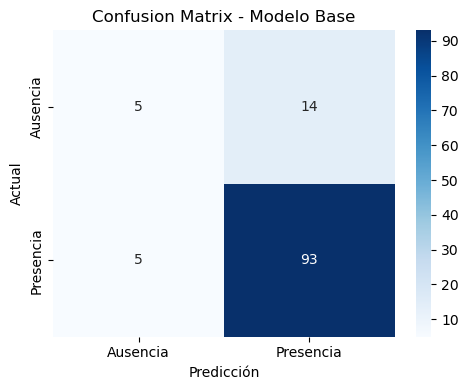


---- MODELO TUNED ----

Principales Métricas de Clasificación:
  Accuracy  : 0.9402
  Precision : 0.9789
  Recall    : 0.9490
  F1        : 0.9637
  ROC_AUC   : 0.9876


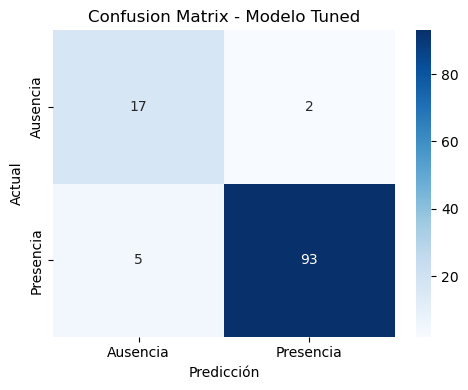

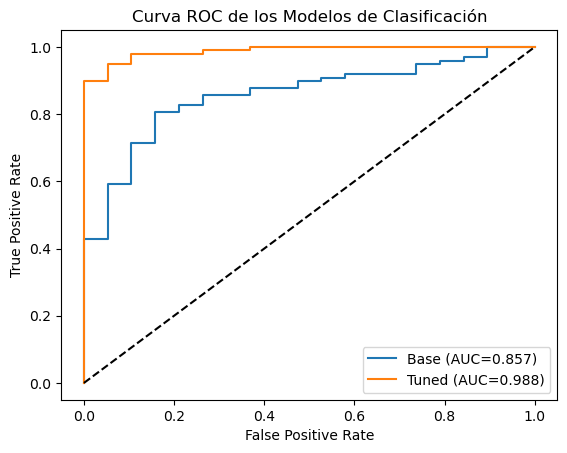

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from evaluating import get_metrics

# Primero cargamos los modelos
model_base = resnet18(weights=ResNet18_Weights.DEFAULT)
model_base.fc = nn.Linear(model_base.fc.in_features, 1)
model_base.load_state_dict(torch.load("../models/recognition_base.pth"))
model_base.to(device)

model_tuned = resnet18(weights=ResNet18_Weights.DEFAULT)
model_tuned.fc = nn.Linear(model_tuned.fc.in_features, 1)
model_tuned.load_state_dict(torch.load("../models/recognition_tuned.pth"))
model_tuned.to(device)

# Ahora evaluamos y obtenemos las principales métricas de cada uno
class_names = ['Ausencia','Presencia'] # se usará para las matrices de confusión
metrics_base, cm_base, roc_base = get_metrics(model_base, val_loader, device, task='binary')
metrics_tuned, cm_tuned, roc_tuned   = get_metrics(model_tuned, val_loader, device, task='binary')

# Por últimos, las mostramos
print("\n---- MODELO BASE ----\n")
print("Principales Métricas de Clasificación:")
for k, v in metrics_base.items():
    print(f"  {k:<10}: {v:.4f}")

# Confusion Matrix del Modelo Base
plt.figure(figsize=(5, 4))
sns.heatmap(cm_base, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Modelo Base")
plt.tight_layout()
plt.show()

print("\n---- MODELO TUNED ----\n")
print("Principales Métricas de Clasificación:")
for k, v in metrics_tuned.items():
    print(f"  {k:<10}: {v:.4f}")

# Confusion Matrix del Modelo Tuned
plt.figure(figsize=(5, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicción")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Modelo Tuned")
plt.tight_layout()
plt.show()

# Curva ROC
plt.figure()
plt.plot(roc_base[0], roc_base[1], label=f"Base (AUC={metrics_base['ROC_AUC']:.3f})")
plt.plot(roc_tuned[0], roc_tuned[1], label=f"Tuned (AUC={metrics_tuned['ROC_AUC']:.3f})")
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC de los Modelos de Clasificación")
plt.legend()
plt.show()